## Evaluate dissolved Mn model concentrations with observations 

Using 2021 IDP GEOTRACES

In [274]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import sys
sys.path.insert(1, '/ocean/brogalla/GEOTRACES/analysis-brogalla/paper1/figures/')
import modules.mapping_functions as mf
import glob
from datetime import datetime
import pickle
import xarray as xr
import gsw

%matplotlib inline

#### Parameters:

In [275]:
obs_color   = '#e54141'
model_color = '#33c7ff'

#### Observations:

In [276]:
# GEOTRACES 2021 Intermediate data product:
folder_data = '/ocean/brogalla/GEOTRACES/data/'
sw          = xr.open_dataset(f'{folder_data}IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_kYw7mpQ2.nc')
GTR_cruises = np.array(sw['metavar1'])
GTR_lons    = sw['longitude'].values # degrees east
GTR_lats    = sw['latitude'].values  # degrees north
GTR_pres    = sw['var1'].values      # Pressure from CTD sensor [dbar]
GTR_depth   = sw['var2'].values      # Depth below sea surface calculated from pressure [m]
GTR_temp    = sw['var3'].values      # Temperature from CTD sensor in the ITS-90 convention. [C]
GTR_sal     = sw['var4'].values      # Practical salinity from CTD sensor on the PSS-1978 scale
GTR_dMn     = sw['var12'].values     # Concentration of dissolved Mn in nmol/kg, method may include Mn(II) plus Mn(III)
GTR_date    = sw['date_time'].values # Decimal Gregorian Days of the station
GTR_stn     = sw['metavar2'].values  # Station names

GTR_pressure   = np.ma.masked_where(GTR_pres < -1e8, GTR_pres)
# practical salinity --> absolute salinity (g/kg)
GTR_lons_tile  = np.tile(GTR_lons, (345,1)).transpose()
GTR_lats_tile  = np.tile(GTR_lats, (345,1)).transpose()
GTR_sal_abs    = gsw.conversions.SA_from_SP(GTR_sal, GTR_pressure, GTR_lons_tile, GTR_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
GTR_density    = gsw.density.rho_t_exact(GTR_sal_abs, GTR_temp, GTR_pressure) # kg/m3

# convert dMn from nmol/kg --> nmol/L (nmol/kg * kg/m3 * 1 m3 / 1000 L)
GTR_dMn_nM = GTR_dMn*GTR_density*1e-3

In [155]:
# Within domain:
GTR_lons_ma = np.ma.masked_where((GTR_lats > 85) | (GTR_lons > 290) | ((GTR_lons < 200) & ((GTR_lats > 78))) \
                                 | ((GTR_lons < 203) & (GTR_lats < 74)) | (GTR_cruises != b'GN01'), GTR_lons)
GTR_lats_ma = np.ma.masked_where((GTR_lats > 85) | (GTR_lons > 290) | ((GTR_lons < 200) & ((GTR_lats > 78))) \
                                 | ((GTR_lons < 203) & (GTR_lats < 74)) | (GTR_cruises != b'GN01'), GTR_lats)
GTR_date_ma = np.ma.masked_where((GTR_lats > 85) | (GTR_lons > 290) | ((GTR_lons < 200) & ((GTR_lats > 78))) \
                                 | ((GTR_lons < 203) & (GTR_lats < 74)) | (GTR_cruises != b'GN01'), GTR_date)
GTR_lons[GTR_lons > 180] = GTR_lons[GTR_lons > 180]-360
GTR_lons_m  = GTR_lons[~GTR_date_ma.mask]
GTR_lats_m  = GTR_lats[~GTR_date_ma.mask]
GTR_stn_m   = GTR_stn[~GTR_date_ma.mask]

In [278]:
for stn in GTR_stns_used:
    print(GTR_date[GTR_stn==stn])

['2015-08-19T16:32:46.999939072']
['2008-08-26T01:50:59.000000728' '2015-08-20T08:48:51.999941920']
['2008-08-27T19:38:59.000003416' '2015-08-21T07:00:10.000103328']
['2015-09-19T17:17:29.999769792']
['2015-09-23T08:01:04.000350240']
['2015-09-26T18:18:07.000008288']
['2015-09-27T13:58:25.999829248']
['2015-09-28T17:14:07.000005856']
['2015-09-28T22:21:29.999990176']
['2015-10-03T12:06:02.999720864']


#### Model:

In [288]:
# Template file structure:
year=2015
r = nc.Dataset(f'/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-{year}_20211012/ANHA12_EXH006_{year}_monthly.nc')
lon_model = np.array(r.variables['nav_lon'])[:,:]
lat_model = np.array(r.variables['nav_lat'])[:,:]
deptht    = np.array(r.variables['deptht'])

#### Functions:

In [289]:
def calculate_average(folder_ref_2015):
    # Calculate average over data files during cruise period:
    # 2015 US GEOTRACES: 19 August - October 3rdd
    files_2015      = np.sort(glob.glob(f'{folder_ref_2015}ANHA12_EXH006_5d_20150101_20151231*'))
    start_date_2015 = datetime.strptime(f'2015-08-19', '%Y-%m-%d')
    end_date_2015   = datetime.strptime(f'2015-10-03', '%Y-%m-%d')

    file_list_2015 = []
    for file in files_2015:
        if (datetime.strptime(file.split('/')[-1][42:50],'%Y%m%d') >= start_date_2015) & \
                    (datetime.strptime(file.split('/')[-1][51:59],'%Y%m%d') < end_date_2015):
            file_list_2015.append(file)

    dmn_2015 = np.zeros((50,700,640))
    omn_2015 = np.zeros((50,700,640))
    days = 0
    for file in file_list_2015:
        ds = xr.open_dataset(f"{file}")
        dmn_2015 = dmn_2015 + ds['dissolmn'].values[0,:,:,:]
        omn_2015 = omn_2015 + ds['oxidismn'].values[0,:,:,:]

    mn_dis_ref_2015 = dmn_2015 / len(file_list_2015)
    mn_oxi_ref_2015 = omn_2015 / len(file_list_2015)
    
    return mn_dis_ref_2015, mn_oxi_ref_2015

In [290]:
def plot_profiles(name, ax, model_depth, model_dmn, obs_depth, obs_dMn, ylim=(1000,0)): 
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xlim(0, 10)
#     ax.set_xticks([0,1,2,3,4,5])
#     ax.set_xticklabels([0,'',2,'',4])
    ax.plot(model_dmn*1e9, model_depth, c=model_color, label='Model')
    ax.plot(obs_dMn, obs_depth, c=obs_color, markersize=7, marker='.', markeredgecolor='k', label='Observations')
    
    title=str(name,'utf-8')
    ax.set_title(f'Stn: {title}', fontsize=6)
    ax.set_ylim(ylim[0],ylim[1])
    ax.tick_params(axis='both', labelsize=6)
    
#     if name=='CAA1':
#         ax.legend(fontsize=6, loc=(0.2, 1.2), frameon=False)
        
    return

### Plot:

In [291]:
dmn_2015, omn_2015 = calculate_average('/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-2015_20211012/')

In [292]:
# array([b'9', b'10', b'11', b'12', b'13', b'14', b'15', b'16', b'44',
#        b'45', b'46', b'47', b'48', b'49', b'50', b'51', b'52', b'53',
#        b'54', b'55', b'56', b'57'], dtype='|S16')
GTR_stns_used = [b'10', b'12', b'14', b'46', b'48', b'51', b'52', b'53', b'54', b'57']
GTR_depth_lim = [500, 2000, 3000, 4000, 4000, \
                 4000, 4000, 4000, 4000, 4000]

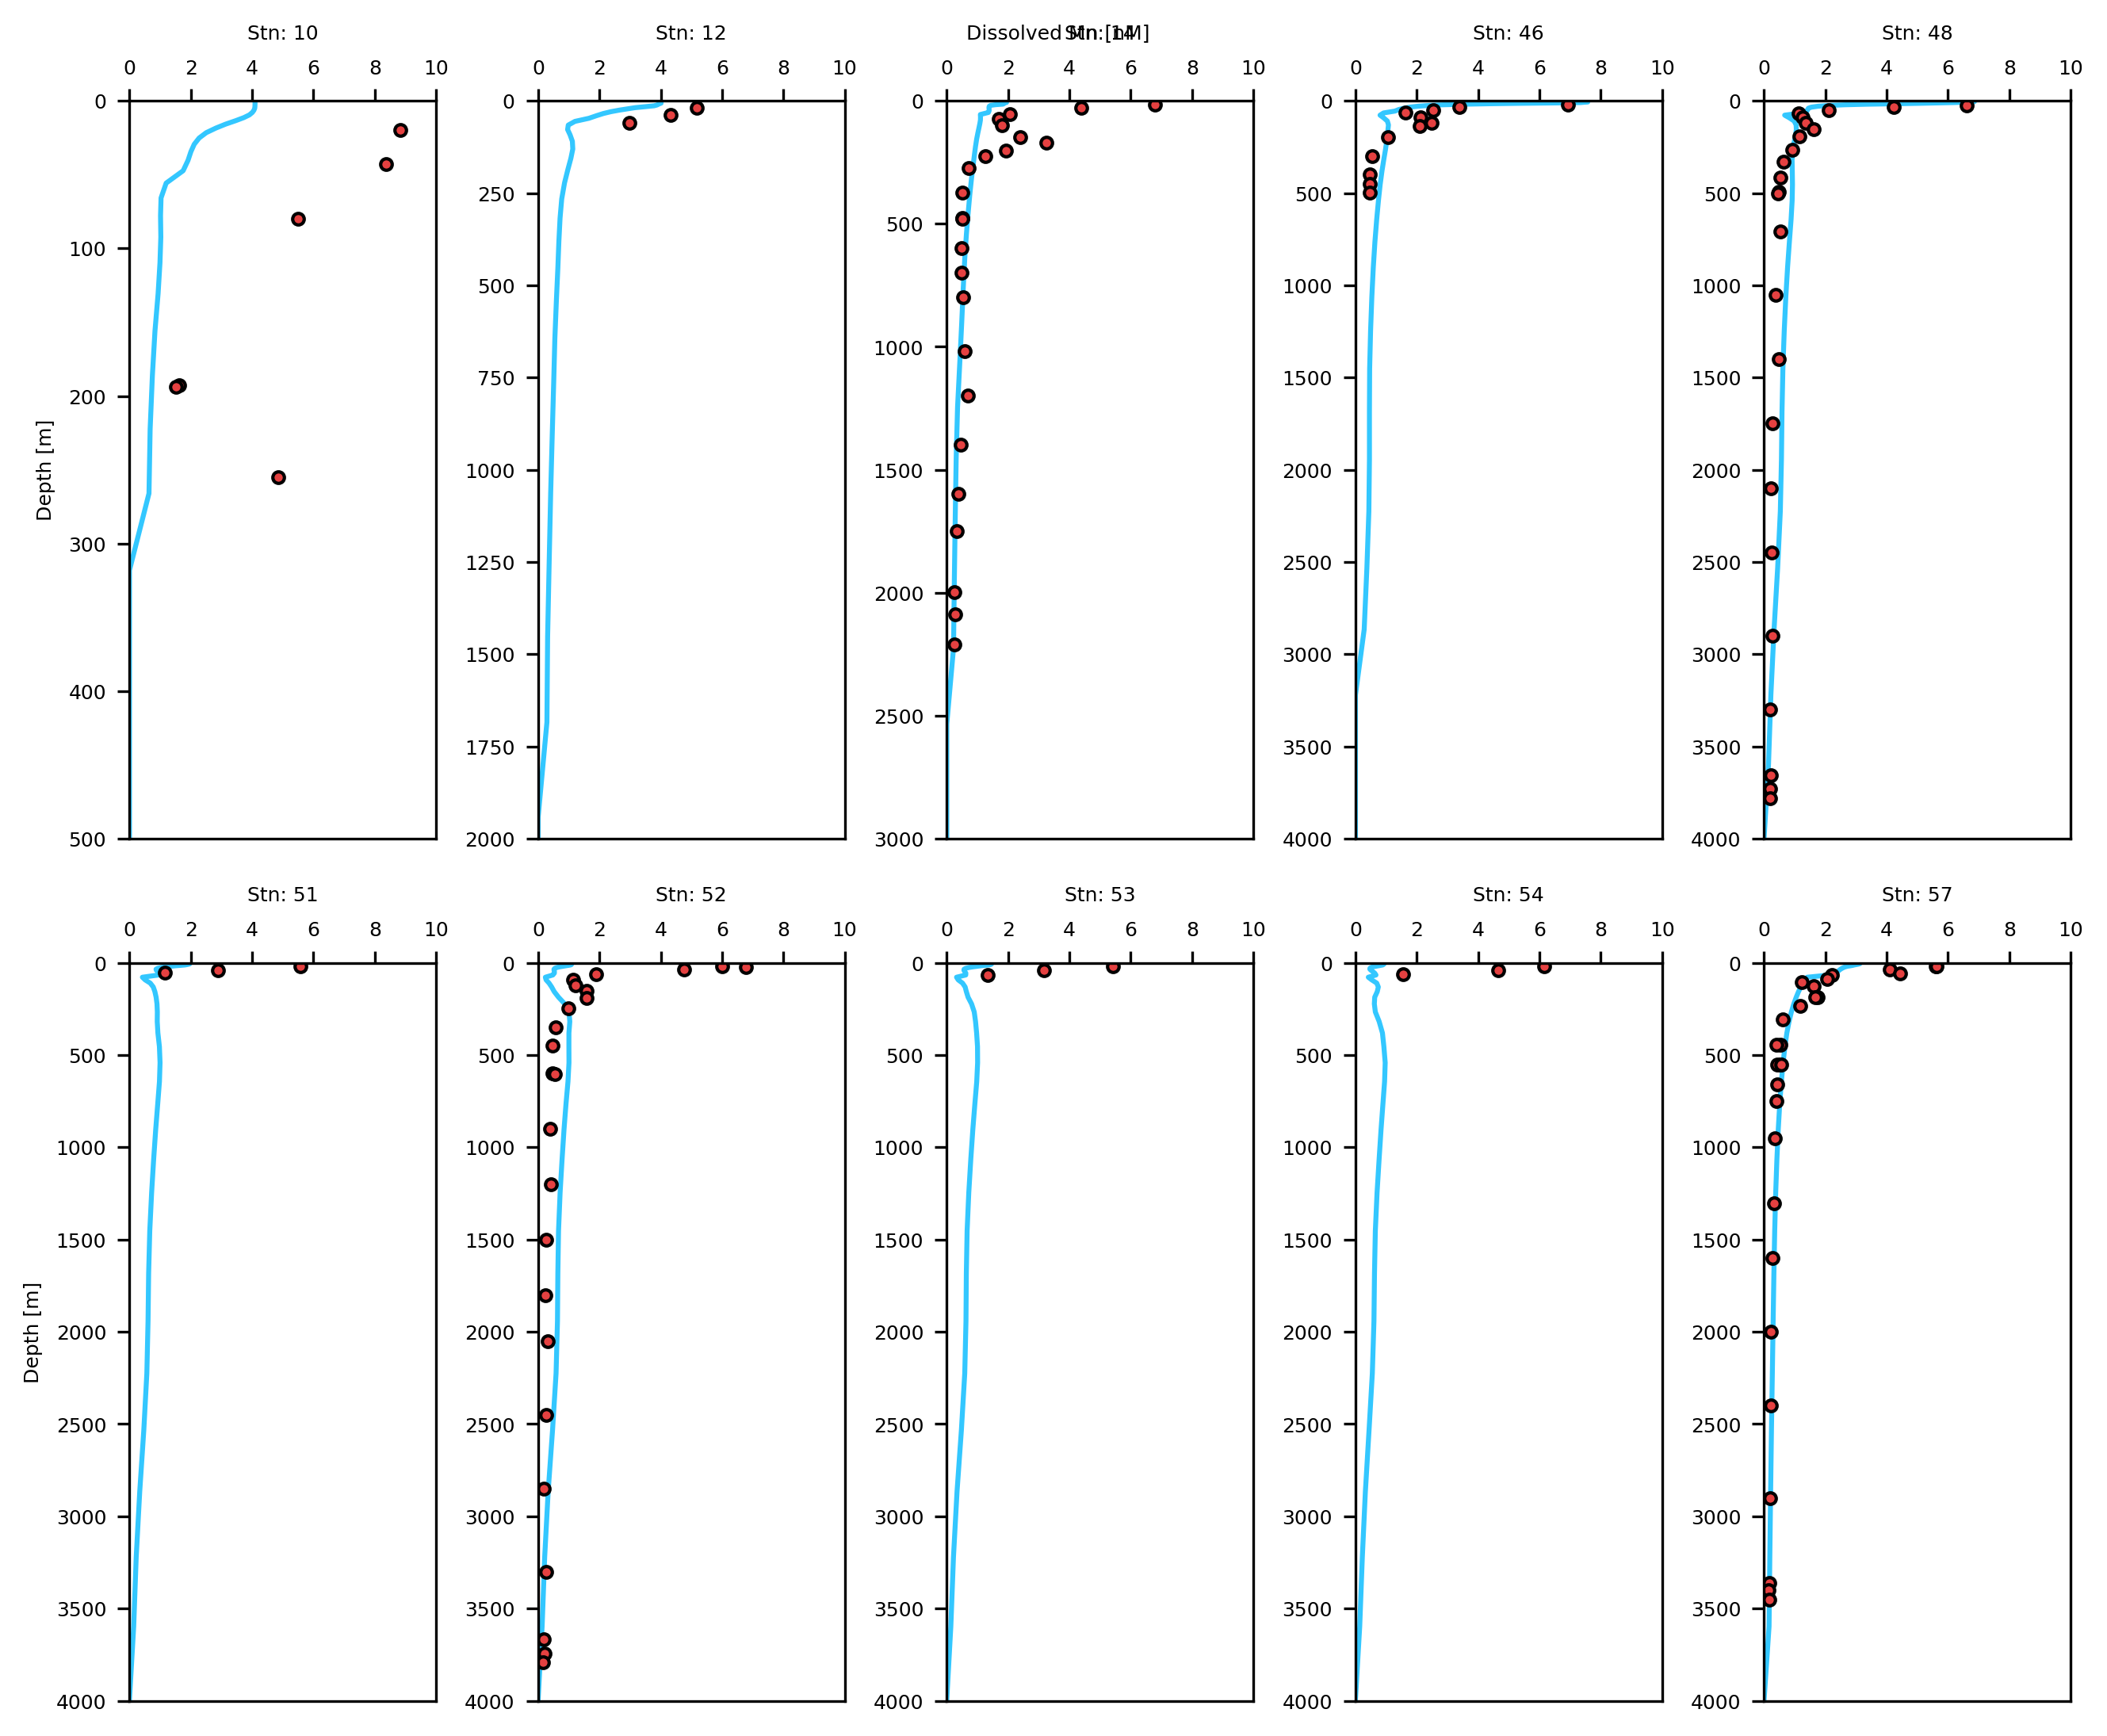

In [304]:
fig, ax = plt.subplots(2,5,figsize=(4.5*2, 3.7*2), dpi=300)

for n, stn in enumerate(GTR_stns_used):
    i, j = mf.find_indeces_vector(GTR_lons_m[GTR_stn_m==stn], GTR_lats_m[GTR_stn_m==stn], lon_model, lat_model)
    if n < 5:     
        plot_profiles(stn, ax[0,n], deptht, dmn_2015[:,int(i),int(j)], \
                      GTR_depth[GTR_stn==stn].flatten(), GTR_dMn_nM[GTR_stn==stn].flatten(), ylim=(GTR_depth_lim[n], 0))
    else:
        plot_profiles(stn, ax[1,n-5], deptht, dmn_2015[:,int(i),int(j)], \
                      GTR_depth[GTR_stn==stn].flatten(), GTR_dMn_nM[GTR_stn==stn].flatten(), ylim=(GTR_depth_lim[n], 0))
        
fig.suptitle('Dissolved Mn [nM]', fontsize=6)
    
ax[0,0].set_ylabel('Depth [m]', fontsize=6)
ax[1,0].set_ylabel('Depth [m]', fontsize=6)

# plt.tight_layout(pad=0.2, w_pad=1.7, h_pad=0.2)
fig.tight_layout(w_pad=0.2)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/S20-evaluation.jpg', \
#                bbox_inches='tight', dpi=300)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/S20-evaluation.svg', \
#                format='svg', bbox_inches='tight', dpi=300)

In [ ]:
# array([b'9', b'10', b'11', b'12', b'13', b'14', b'15', b'16', b'44',
#        b'45', b'46', b'47', b'48', b'49', b'50', b'51', b'52', b'53',
#        b'54', b'55', b'56', b'57'], dtype='|S16')
GTR_stns_used = [b'46', b'48', b'51', b'52', b'53', b'54', b'57']
GTR_depth_lim = [4000, 4000, \
                 4000, 4000, 4000, 4000, 4000]

In [295]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
ANHA12_lon   = np.array(mesh.variables['nav_lon'])
ANHA12_lat   = np.array(mesh.variables['nav_lat'])
ANHA12_bathy = np.array(mesh.variables['hdept'][0])

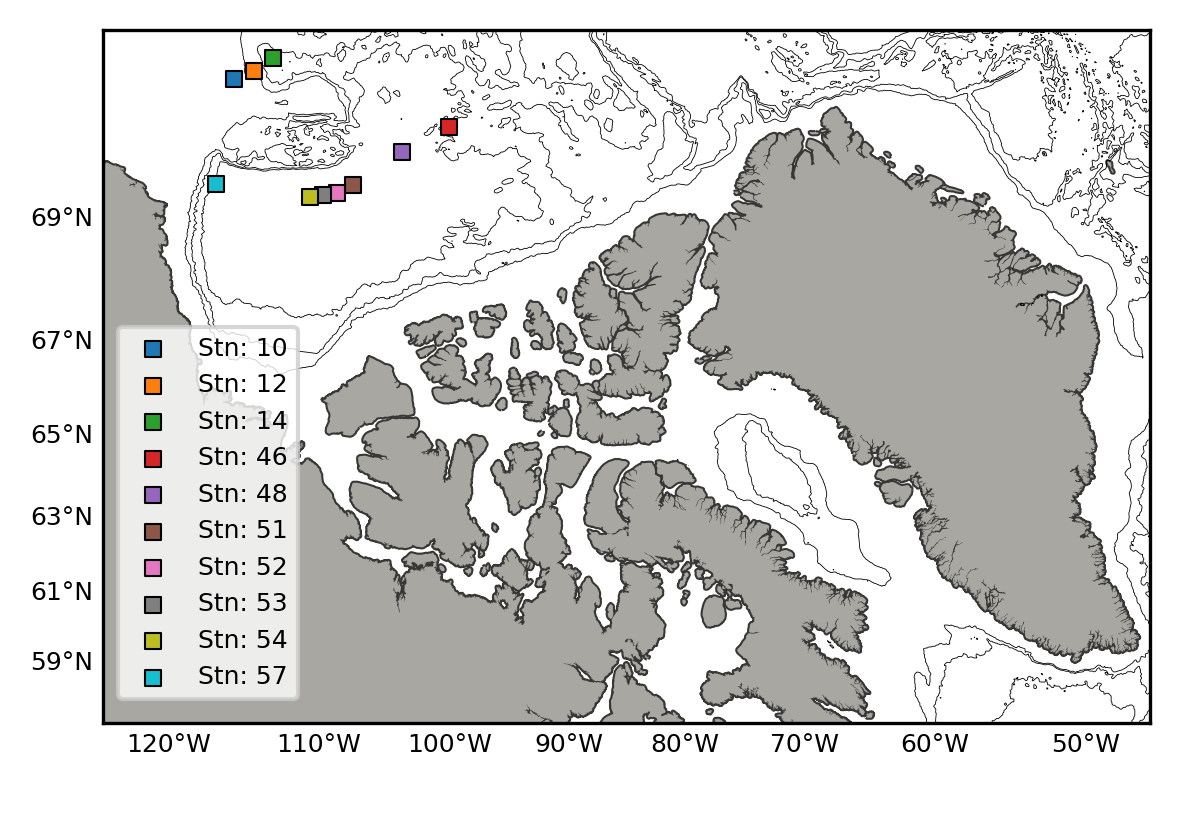

In [296]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

x, y = proj1(ANHA12_lon, ANHA12_lat)
proj1.contour(x, y, ANHA12_bathy, levels=[1000,2000,3000], linewidths=0.2, colors='k', zorder=3)

x_GTR, y_GTR = proj1(GTR_lons, GTR_lats)

for stn in GTR_stns_used:
    stn_name = str(stn,'utf-8')
    proj1.scatter(x_GTR[GTR_stn==stn], y_GTR[GTR_stn==stn], s=15, zorder=3, edgecolor='k', marker='s', linewidth=0.5, label=f'Stn: {stn_name}')
    
fig.legend(loc=(0.10, 0.14), fontsize=6)